# Finalize clusters

- removes unwanted (empty) clusters.
- splits big cluster mannualy.
- save final clusters - mapping between barcodes and clusters
- finds final markers
- creates final heatmap
- save tSNE with barcodes

In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
lib6 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts/preprocess_data'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
sys.path.append(lib6)
from classifying_cell_types import *
from utilities.general_helpers import *
# ------- SERVER EXTENSIONS ---------
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
from utilities.ML_environment import find_marker_genes_in_cluster
import pickle
# from Bio.Cluster import kcluster
# from Bio.Cluster import kcluster
# import pyclustering
from utilities.ML_environment import find_marker_genes_in_cluster
import os
import numpy as np
import yaml
from os.path import join
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import statsmodels as sm
import scipy.stats as stats
from scipy.stats import rankdata
from sklearn.manifold import TSNE
import pickle
import numpy as np
from utilities.general_helpers import flatten_list
# from utilities.ML_environment import find_marker_genes_in_cluster
from shutil import copyfile
import matplotlib.pyplot as plt
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters
from utilities.general_helpers import are_the_lists_identical
from utilities.clustering_tools import get_clusters_indices, find_satisfying_list_of_markers_in_clusters

Loads cohort:

In [ ]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21_protein_coding_genes.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

In [ ]:
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

In [4]:
K = 15
kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


In [5]:
clusters_cells = [filtered_cells[cluster_indices] for cluster_indices in clusters]

# Creates DF

removes clusters (the corresponding barcodes) from the DF.
clusters indexes in DF will be serial starts from 1, and not compatible with original cluster numbers.

In [7]:
df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])

# [cls.number_of_cells for cls in clusters_cells]
cluster_idx = 1
lines =''
for idx, cls in enumerate(clusters_cells):  
    if cls.number_of_cells > 30:
        lines += f'\norig: {idx}, new: {cluster_idx}'
        df = df.append(pd.DataFrame(transpose_list([cls.samples, cls.barcodes, [cluster_idx]*cls.number_of_cells]), columns=df.columns))
        cluster_idx += 1
    else:
        print(f'cluster {idx+1} contains {cls.number_of_cells} cells (less than 30 cells) and therefore excluded from DF')
print(lines)

df = df.reset_index()

cluster 2 contains 2 cells (less than 30 cells) and therefore excluded from DF
cluster 6 contains 3 cells (less than 30 cells) and therefore excluded from DF
cluster 9 contains 1 cells (less than 30 cells) and therefore excluded from DF
cluster 13 contains 1 cells (less than 30 cells) and therefore excluded from DF

orig: 0, new: 1
orig: 2, new: 2
orig: 3, new: 3
orig: 4, new: 4
orig: 6, new: 5
orig: 7, new: 6
orig: 9, new: 7
orig: 10, new: 8
orig: 11, new: 9
orig: 13, new: 10
orig: 14, new: 11


In [8]:
df.groupby('Cluster').count().reset_index()

,Cluster,index,Sample,Barcode
0,1,15181,15181,15181
1,2,4537,4537,4537
2,3,3385,3385,3385
3,4,2950,2950,2950
4,5,12924,12924,12924
5,6,10061,10061,10061
6,7,4726,4726,4726
7,8,10521,10521,10521
8,9,6522,6522,6522
9,10,3341,3341,3341


##### Saves final DF of mapping

if you want to split some clusters, don't save yet. only after you finish the next step.

In [9]:
# CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
# df.to_csv(CSV_PATH)

# Splits cluster using tSNE

If there's a big cluster where you see in heatmaps that the markers assoicated with half of the cells, you can split it to two.

If not - just skip these blicks.

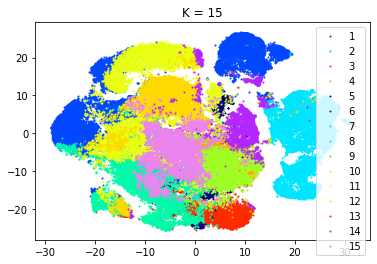

In [10]:
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune_cells_bhtsne_26.6.21.pkl'

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,15)])[[2, 5, 11, 10, 0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14]]


for cluster_idx, cluster_list in enumerate(clusters):
    Xi = cells_embedded[cluster_list, 0]
    Yi = cells_embedded[cluster_list, 1]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx], label=cluster_idx+1, markersize=1)

    plt.legend()
plt.title(f"K = {K}");
plt.show()


In [11]:
cluster_1 = clusters[0]
Xi = cells_embedded[cluster_1, 0]
Yi = cells_embedded[cluster_1, 1]
left_side_indices = np.array(cluster_1)[Xi < -5]
right_side_indices = np.array(cluster_1)[Xi >= -5]
left_cluster = filtered_cells[left_side_indices]
right_cluster = filtered_cells[right_side_indices]

In [12]:
# Sanity check - should be TRUE (identical)
are_the_lists_identical(left_cluster.barcodes + right_cluster.barcodes, df[df['Cluster']==1]['Barcode'].tolist())

True

In [13]:
df['Cluster'] = df.apply(lambda x: 12 if (x['Barcode'], x['Sample']) in list(zip(left_cluster.barcodes,left_cluster.samples)) else x['Cluster'], axis=1)
df.groupby('Cluster').count()

,index,Sample,Barcode
Cluster,,,
1,6505,6505,6505
2,4537,4537,4537
3,3385,3385,3385
4,2950,2950,2950
5,12924,12924,12924
6,10061,10061,10061
7,4726,4726,4726
8,10521,10521,10521
9,6522,6522,6522


##### Saves final DF of mapping

In [15]:
CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df.to_csv(CSV_PATH)

# find marker genes in final clusters
Mainly for drawing a heatmap

In [4]:
CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df = pd.read_csv(CSV_PATH)

In [6]:
cluster_indexes = get_clusters_indices(df, filtered_cells)

In [8]:
cluster_markers_list = find_satisfying_list_of_markers_in_clusters(filtered_cells, list(cluster_indexes.values()))

Progress: 1/12
Progress: 2/12
Progress: 3/12
Progress: 4/12
Progress: 5/12
Progress: 6/12
Progress: 7/12
Progress: 8/12
Progress: 9/12
Progress: 10/12
Progress: 11/12
Progress: 12/12


##### Saves the PKL version

In [24]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21'
K = 12
pickle.dump((cluster_markers_list), open(os.path.join(OUTPUT_PATH, f'cluster_analysis_k_{K}.pkl'), 'wb'))

##### Saves the Excel version

In [9]:
markers_df = pd.DataFrame()
for cluster_markers in cluster_markers_list:
    gene_markers = cluster_markers['markers']['gene names'].tolist()[:100]
    if len(gene_markers) <100:
        gene_markers += [None] * (100 - len(gene_markers))
    markers_df[cluster_markers['cluster id']+1] = gene_markers


In [11]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/markers.csv'

markers_df.to_csv(OUTPUT_PATH)

# tSNE

##### Runs the next block only if you start the run from here:

In [27]:
# CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
# df = pd.read_csv(CSV_PATH)

# clusters_indexes = get_clusters_indices(df, filtered_cells)

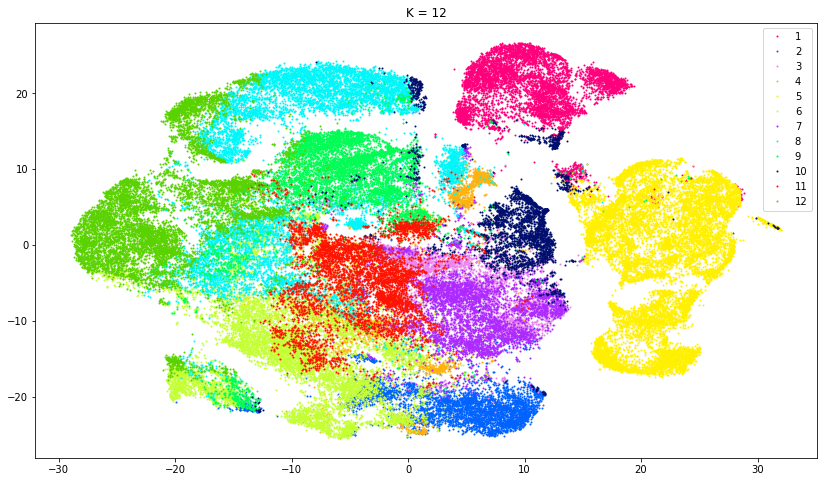

In [26]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/tSNE.png'
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune_cells_bhtsne_26.6.21.pkl'



plt.rcParams["figure.figsize"] = 14, 8 #plt.rcParamsDefault["figure.figsize"]

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 15, 99, 70, 60, 53,  92, 23,  32,  1, 80, 40, 12, 13, 14]]
# colors = np.array([colormap(i) for i in np.linspace(0, 0.9,15)])[[2, 5, 11, 10, 0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14]]

for cluster_idx, cluster_list in cluster_indexes.items():
    Xi = cells_embedded[cluster_list, 0]
    Yi = cells_embedded[cluster_list, 1]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx-1], label=cluster_idx, markersize=1)

    plt.legend()
plt.title(f"K = {K}");
# plt.show()

# remove if you dont want to save
plt.savefig(OUTPUT_PATH)

# Elbow

See original elbow plot:

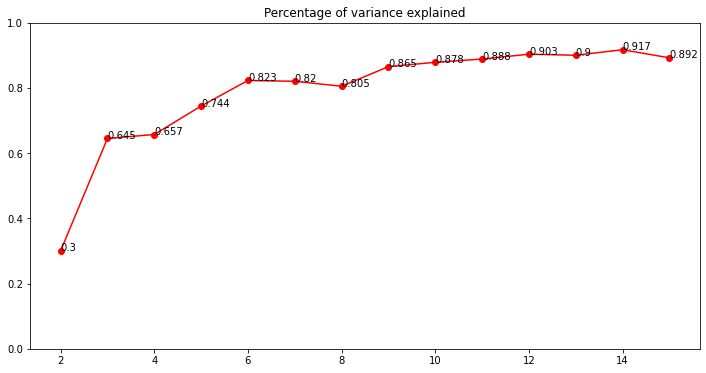

In [4]:
elbow_pickle_path = r'/storage/md_keren/shitay/outputs/clustering/immune/elbow/26.6.21_cohort/elbow.pkl'

elbow = pickle.load(open(elbow_pickle_path, 'rb'))

All_Dist_b = elbow['Ks_Dist_b']
Dis_t = elbow['Dis_t']

plt.figure(figsize=(12,6))
distances = [(ii/2)/Dis_t for ii in All_Dist_b.values()]
plt.plot(list(All_Dist_b.keys()), distances, '-or');
plt.ylim((0,1));
distances_dic = dict(zip(list(All_Dist_b.keys()),distances))
for a,b in distances_dic.items(): 
    plt.text(a, b, str(round(b,3)))
plt.title('Percentage of variance explained');
# plt.savefig(r'/storage/md_keren/shitay/outputs/clustering/elbow/26.6.21_cohort/elbow_fig.jpg')

In [8]:
distances_dic

{2: 0.3004110881016862,
 3: 0.6450137002489867,
 4: 0.6570072374374855,
 5: 0.7443679609183536,
 6: 0.8226185244642041,
 7: 0.8201933963268462,
 8: 0.8050225749145106,
 9: 0.8650123604143531,
 10: 0.8784806300586576,
 11: 0.8883585480052613,
 12: 0.903235046970184,
 13: 0.9000047969014203,
 14: 0.9169649453375096,
 15: 0.8922060877882262}

Loads the pair-wise correlation distances of all points: 

In [5]:
CDIST_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/kmeans/26.6.21/cdist.pkl'
D = pickle.load(open(CDIST_PATH, 'rb'))

Calculates the percentage of variance explained' of new K=12:

In [12]:
K = 12


COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/immune_cells_26.6.21_4k_genes.pkl'
immune_cells = pickle.load(open(COHORT_PATH, 'rb'))


CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df = pd.read_csv(CSV_PATH)

clusters_indexes = get_clusters_indices(df, immune_cells)
clusters = list(clusters_indexes.values())

Dist_b = 0
for idx in range(len(clusters)):
    cluster_indices = clusters[idx]
    other_clusters_indices = [ii for ii in range(immune_cells.number_of_cells) if not ii in cluster_indices]

    for ii in cluster_indices:
        for jj in other_clusters_indices:
            Dist_b += D[ii, jj]

p_variance_explained = (Dist_b/2)/Dis_t
print(f'The percentage of variance explained of k={K} is: {p_variance_explained}')

The percentage of variance explained of k=12 is: 0.9073984972941981


Now you should replace the value ('percentage of variance explained') of K=12 only.

In [25]:
distances_dic[K] = p_variance_explained
distances[K-2] = p_variance_explained

Prints the updated elbow values:

FileNotFoundError: [Errno 2] No such file or directory: '/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/elbow.png'

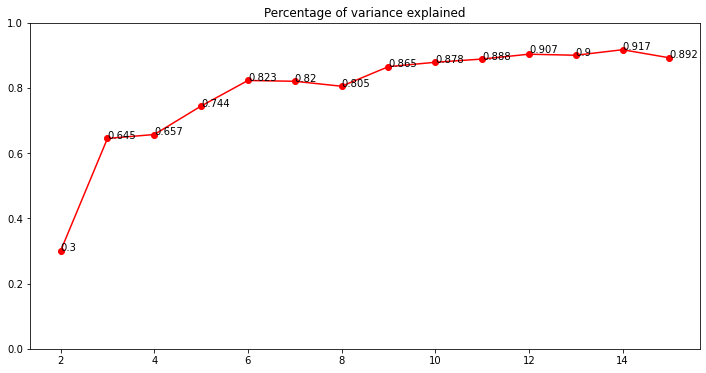

In [27]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/elbow.png'

plt.figure(figsize=(12,6))
distances = [(ii/2)/Dis_t for ii in All_Dist_b.values()]
plt.plot(list(All_Dist_b.keys()), distances, '-or');
plt.ylim((0,1));

for a,b in distances_dic.items(): 
    plt.text(a, b, str(round(b,3)))
plt.title('Percentage of variance explained');

plt.savefig(OUTPUT_PATH)

# Debug

In [108]:
K=15
CLUSTERING_ANALYSIS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/cluster_analysis/cluster_analysis_26.6.21'
clustering_analysis = pickle.load(open(join(CLUSTERING_ANALYSIS_PATH, f'cluster_analysis_k_{K}.pkl'), 'rb'))

In [109]:
clustering_analysis
[len(v['markers']) for v in clustering_analysis]


[93, 0, 1445, 154, 178, 3, 1346, 74, 0, 252, 228, 37, 1, 1757, 17]

In [2]:
CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df = pd.read_csv(CSV_PATH)

In [3]:
df.groupby('Cluster').count()

,Unnamed: 0,index,Sample,Barcode
Cluster,,,,
1,6505,6505,6505,6505
2,4537,4537,4537,4537
3,3385,3385,3385,3385
4,2950,2950,2950,2950
5,12924,12924,12924,12924
6,10061,10061,10061,10061
7,4726,4726,4726,4726
8,10521,10521,10521,10521
9,6522,6522,6522,6522


In [8]:
immune_cells

In [19]:
CD8B_idx = immune_cells.gene_names.index('CD8B')
CD8A_idx = immune_cells.gene_names.index('CD8A')


In [28]:
cytox_cells_indices = np.sum(immune_cells.counts[:, [CD8A_idx, CD8B_idx]]>0, axis=1) > 0 
cytox_cells = immune_cells[cytox_cells_indices]

In [34]:
Counter(flatten_list(cytox_cells.cells_information.getattr('cell_type_list')))

Counter({'T cells': 25815,
         'Immune_general': 29732,
         'CD8 Cytotoxic T cells': 25815,
         'Exhausted T cells': 13736,
         'Activated T cells': 956,
         'Neutrophils': 175,
         'NKT cells': 1200,
         'CD4 helper T cells': 297,
         'Memory CD8 T cells': 262,
         'B cells': 53,
         'Regulatory CD4_CD8 T cells': 42,
         'Memory CD4_CD8 T cells': 16,
         'Monocyte_mature': 20,
         'Regulatory CD8 T cells': 66,
         'Macrophage_mature': 18,
         'myeloid cells_general_mature': 19,
         'Macrophage_immature': 1,
         'cDCs_dendritic_cells': 18,
         'Granolocytes': 5,
         'Stem_like T cells': 1,
         'pDCs': 2,
         'myeloid cells_general_immature': 1})

In [36]:
cytox_cells.number_of_cells



29732

In [40]:
['CD8 Cytotoxic T cells' in types for types in cytox_cells.cells_information.getattr('cell_type_list')]
sum(immune_cells.cells_information.getattr('is_myeloid'))

12025

In [42]:
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune/immune_cells_bhtsne_26.6.21.pkl'

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))


In [52]:
df = pd.DataFrame(cells_embedded, columns=['x','y'])
df['barcode'] =['bb']*len(cells_embedded)
df

,x,y,barcode
0,-5.167627,-10.144765,bb
1,17.194327,4.326343,bb
2,3.540960,-5.953288,bb
3,-0.208077,-4.388306,bb
4,17.744799,5.319639,bb
...,...,...,...
79495,-3.009398,-10.898353,bb
79496,-16.500784,-5.084525,bb
79497,-4.166076,-10.356136,bb
79498,-4.749731,-6.441510,bb
